# Quantifying National Forest Accessibility

Quantifying accessibility to National Forest hiking trails based on travel time is an essential part of understanding the public benefit provided by NFS. The accessibility zone refers to the geographic area from which people can reach a particular site, such as a hiking trail, within a given travel time.

In [63]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, LineString, box
import osmnx as ox
import networkx as nx
import folium
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='osmnx')

1. Prepare Input Data

We start with a map of the National Forest system in Region 8 (U.S. South). We will eventually be interested in access to old growth access, so we will also want to include observations of old growth forest from the FIA's National Forest Inventory.

Let's use the administrative boundaries from the FS geospatial gateway. 

https://data.fs.usda.gov/geodata/edw/datasets.php

Old growth observations were obtained from FIA datamart

https://research.fs.usda.gov/products/dataandtools/tools/fia-datamart

Old growth forest is defined in this report:

https://www.fs.usda.gov/sites/default/files/fs_media/fs_document/Mature-and-Old-Growth-Forests.pdf

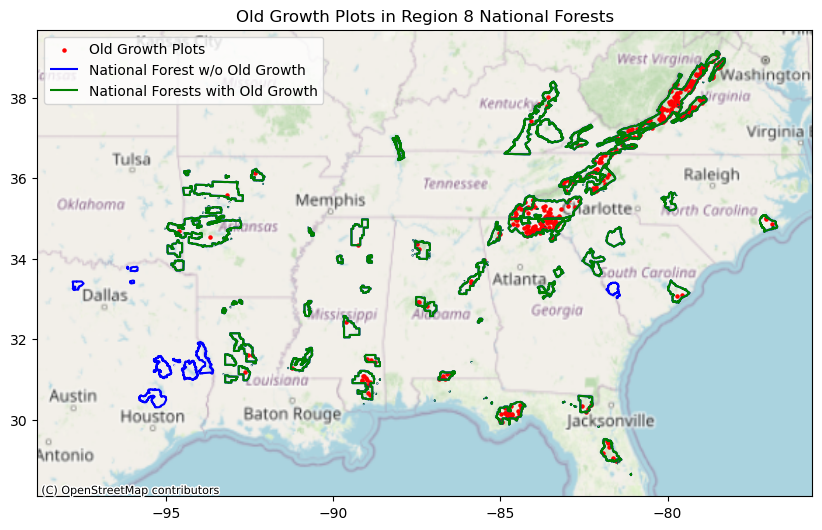

In [64]:
file_path = '/Users/mihiarc/Work/data/'

# load national forest boundaries
forest_boundary = gpd.read_file(file_path + 'spatial-boundaries/nfs-layers/FS Admin Boundaries/S_USA.AdministrativeForest.shp')
forest_boundary_region_8 = forest_boundary[forest_boundary['REGION'] == '08']
# drop El Yunque National Forest, PR
forest_boundary_region_8 = forest_boundary_region_8[forest_boundary_region_8['FORESTNAME'] != 'El Yunque National Forest']
# Load the forest plot data
forest_df = pd.read_csv(file_path + 'MOG_FIA-selected/FIA_2023_PLOT_US_MOG.csv')

# old growth only
# Filter data with specific criteria
forest_df = forest_df[
    (forest_df['LOCATION_NM'].isin(['Alabama', 'North Carolina', 'South Carolina',
                                    'Texas', 'Florida', 'Tennessee', 'Virginia',
                                    'Kentucky', 'Georgia', 'Mississippi',
                                    'Louisiana', 'Arkansas', 'Oklahoma'])) &
    (forest_df['MOG_LABEL'] == 'Old growth') &
    (forest_df['OWNGRPCD'] == 10)
]

# Create a GeoDataFrame with geometry from latitude and longitude
forest_gdf = gpd.GeoDataFrame(
    forest_df,
    geometry=gpd.points_from_xy(forest_df['LON'], forest_df['LAT']),
    crs='EPSG:4326'
)

# select only the national forests that contain points in forest_gdf
forest_boundary_mog = forest_boundary[forest_boundary.intersects(forest_gdf.unary_union)]
fig, ax = plt.subplots(figsize=(10, 10))
forest_gdf.plot(ax=ax, color='red', markersize=5)
forest_boundary_region_8.boundary.plot(ax=ax, color='blue')
forest_boundary_mog.boundary.plot(ax=ax, color='green')
# Add basemap
ctx.add_basemap(ax, crs=forest_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)
# add legend
plt.legend(['Old Growth Plots', 'National Forest w/o Old Growth', 'National Forests with Old Growth'])
plt.title('Old Growth Plots in Region 8 National Forests')
plt.show()

2. Define the access points
   
Next, we load and clean the Hiking Trail data that we also obtained from the Forest Service's geospatial gateway. We want to focus on hiking trails in Region 8 that are no more than 5 miles long and allow for walking. 

Once cleaned, we can use the folium library to create an interactive map.

In [72]:
import os

# load NF trails
file_path = '/Users/mihiarc/Work/data/'
shapefile = os.path.join(file_path, 'spatial-boundaries', 'nfs-layers', 'FS Hiking Trails', 'S_USA.TrailNFS_Publish.shp')
try:
    nfs_trails = gpd.read_file(shapefile)
except FileNotFoundError:
    print("Shapefile not found. Please check the file path.")
    raise

# clip to the region 8 boundary
nfs_trails = gpd.clip(nfs_trails, forest_boundary_region_8)

# select desired variables
nfs_trails_filtered = nfs_trails[['ADMIN_ORG', 'TRAIL_CN', 'TRAIL_NAME', 'TRAIL_NO', 'TRAIL_TYPE',
                         'BMP', 'EMP', 'SEGMENT_LE', 'GIS_MILES', 'SHAPE_LEN', 'geometry']].copy()

# create new columns for region, forest, and ranger district
# ADMIN_ORG format: '080101' where each code is two digits
nfs_trails_filtered['REGION'] = nfs_trails_filtered['ADMIN_ORG'].str[:2]
nfs_trails_filtered['FOREST'] = nfs_trails_filtered['ADMIN_ORG'].str[2:4]
nfs_trails_filtered['RANGER_DISTRICT'] = nfs_trails_filtered['ADMIN_ORG'].str[4:]

# filter trails in region 8, TERRA trail type, and GIS_MILES <= 5
REGION_CODE = '08'
MAX_TRAIL_LENGTH = 5
MAP_CENTER = [34.5, -84]
MAP_ZOOM = 5

filtered_trails = nfs_trails_filtered[
    (nfs_trails_filtered['REGION'] == REGION_CODE) &
    (nfs_trails_filtered['TRAIL_TYPE'] == 'TERRA') &
    (nfs_trails_filtered['GIS_MILES'] <= MAX_TRAIL_LENGTH)
].copy()

# Group by 'TRAIL_NO' and get the index of the minimum 'GIS_MILES' for each group
min_gis_miles_idx = filtered_trails.groupby('TRAIL_NO')['GIS_MILES'].idxmin()

# Use the indices to filter
nfs_trails_region_8_terra_min_gis_miles = filtered_trails.loc[min_gis_miles_idx]

# repeat filtering using 'TRAIL_NAME' 
# Group by 'TRAIL_NAME' and get the index of the minimum 'GIS_MILES' for each group
min_gis_miles_idx = filtered_trails.groupby('TRAIL_NAME')['GIS_MILES'].idxmin()

# Use the indices to filter
filtered_trails = filtered_trails.loc[min_gis_miles_idx]
# drop if missing geometry
filtered_trails = filtered_trails.dropna(subset=['geometry'])
# drop rows with multilinestring geometries
filtered_trails = filtered_trails[
    filtered_trails['geometry'].apply(lambda x: x.geom_type) == 'LineString'
]
# Function to extract the starting point of a trail
def get_starting_point(geometry):
    if geometry.geom_type == 'LineString':
        return geometry.coords[0]
    else:
        return None

# Apply the function to create a new column with the starting point
filtered_trails['starting_point'] = filtered_trails['geometry'].apply(get_starting_point)

# Display the DataFrame with the new column
filtered_trails[['TRAIL_NAME', 'starting_point']]
# make a copy called 'trail_starts' and convert 'starting_point' to a Point object
trail_starts = filtered_trails.copy()
# use folium to plot the trail starting points
import folium
from folium.plugins import MarkerCluster

# Create a folium map centered on Region 8
m = folium.Map(location=MAP_CENTER, zoom_start=MAP_ZOOM)

# Add a marker cluster to the map
marker_cluster = MarkerCluster().add_to(m)

# Add markers for the trail starting points
for idx, row in trail_starts.iterrows():
    coords = row['starting_point']
    if coords is not None:
        folium.Marker(location=[coords[1], coords[0]], popup=row['TRAIL_NAME']).add_to(marker_cluster)

# Display the map
m
# Save the folium map to an HTML file
# m.save('region8_trail_map.html')

3. Calculate travel distance

In [90]:
# print the crs of trail_starts
print("The CRS for trail heads is: " + str(trail_starts.crs))

# convert to projected crs
trail_starts_projected = trail_starts.to_crs(epsg=3857)
trail_starts_projected.crs

The CRS for trail heads is: EPSG:4269


<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

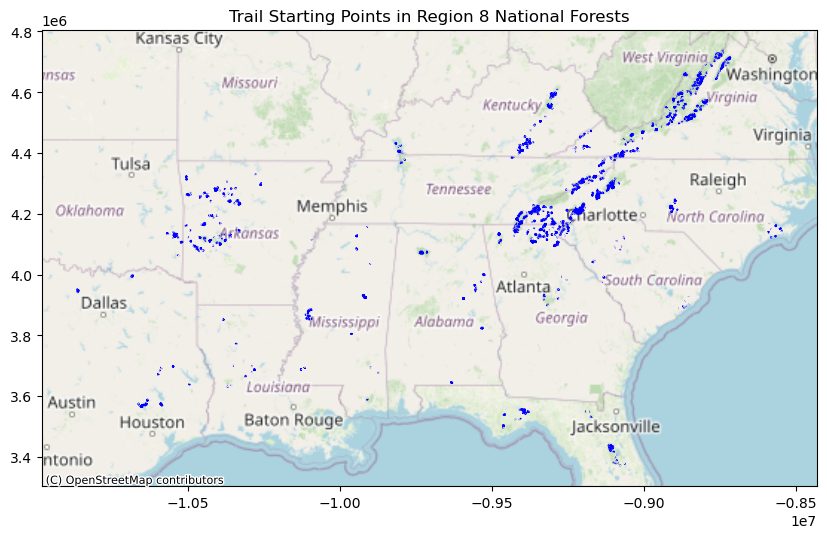

In [75]:
# plot the trails
fig, ax = plt.subplots(figsize=(10, 10))
trail_starts_projected.plot(ax=ax, color='blue', markersize=10)
ctx.add_basemap(ax, crs=trail_starts_projected.crs, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Trail Starting Points in Region 8 National Forests')
plt.show()

In [91]:
# test on a specific trail
trail_name = 'ROBBINS BRANCH'
trail = trail_starts[trail_starts['TRAIL_NAME'] == trail_name].iloc[0]
trail

ADMIN_ORG                                                     081110
TRAIL_CN                                                 5456.006661
TRAIL_NAME                                            ROBBINS BRANCH
TRAIL_NO                                                       TR393
TRAIL_TYPE                                                     TERRA
BMP                                                              0.0
EMP                                                           3.0363
SEGMENT_LE                                                    3.0363
GIS_MILES                                                      3.042
SHAPE_LEN                                                   0.048553
geometry           LINESTRING (-79.948522416 35.59016011199998, -...
REGION                                                            08
FOREST                                                            11
RANGER_DISTRICT                                                   10
starting_point                    

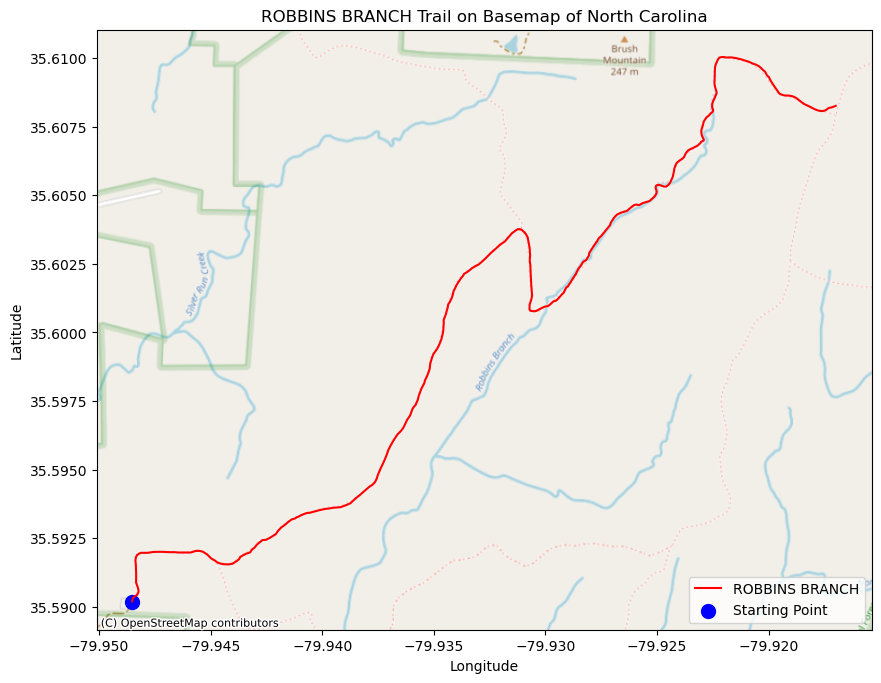

In [92]:
# Filter the trail_starts GeoDataFrame for the "ROBBINS BRANCH" trail
robbins_branch_trail = trail_starts[trail_starts['TRAIL_NAME'] == 'ROBBINS BRANCH']
starting_point = robbins_branch_trail.iloc[0]['starting_point']
# Plot the trail on a basemap
fig, ax = plt.subplots(figsize=(10, 10))
robbins_branch_trail.plot(ax=ax, color='red', markersize=50, label='ROBBINS BRANCH')
# Convert the starting point to a GeoSeries
starting_point_gs = gpd.GeoSeries([Point(starting_point)], crs=robbins_branch_trail.crs)
starting_point_gs.plot(ax=ax, color='blue', markersize=100, label='Starting Point')

# Add basemap
ctx.add_basemap(ax, crs=robbins_branch_trail.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Set plot title and labels
plt.title('ROBBINS BRANCH Trail on Basemap of North Carolina')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='lower right')
plt.show()

/opt/anaconda3/envs/geo/lib/python3.9/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


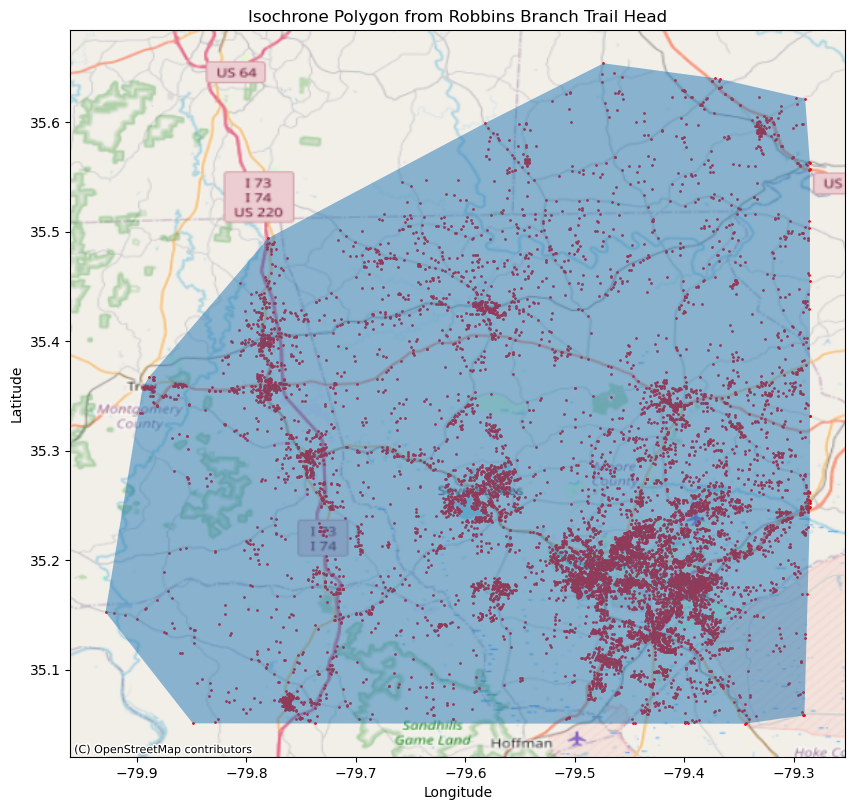

In [106]:
# setup the trail head coordinates
trail_head_coords = (starting_point[1], starting_point[0])

# Define your travel time limit in minutes
travel_time_limit = 60

# Download the road network around the trail head location
G = ox.graph_from_point(trail_head_coords, network_type='drive', dist=travel_time_limit * 1000)

# Add edge speeds and travel times
ox.routing.add_edge_speeds(G)
ox.routing.add_edge_travel_times(G)

# Project the trail head point to match the graph's CRS
trail_head_point = gpd.GeoSeries(
        [Point(trail_head_coords)], crs='EPSG:4269'
    ).to_crs(G.graph['crs'])

# Get the nearest node to the trail head location in the graph
trail_head_node = ox.nearest_nodes(
        G, X=trail_head_point.geometry.x.iloc[0], Y=trail_head_point.geometry.y.iloc[0]
    )

# Convert travel time limit to seconds
travel_time_limit_sec = travel_time_limit * 60

# Find nodes reachable within the travel time limit
subgraph = nx.ego_graph(
        G, trail_head_node, radius=travel_time_limit_sec, distance='travel_time'
    )

# Extract the geometries of the nodes in the subgraph
node_points = [
        Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)
    ]

# Create a GeoDataFrame of the nodes
nodes_gdf = gpd.GeoDataFrame(geometry=node_points, crs=G.graph['crs'])

# Create an isochrone polygon (convex hull)
isochrone = nodes_gdf.unary_union.convex_hull

# Plot the isochrone on a basemap
fig, ax = plt.subplots(figsize=(10, 10))
nodes_gdf.plot(ax=ax, color='red', markersize=1)
gpd.GeoSeries([isochrone]).plot(ax=ax, alpha=0.5)
ctx.add_basemap(ax, crs=nodes_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Set plot title and labels
plt.title('Isochrone Polygon from Robbins Branch Trail Head')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

4. Characterize the communities with access

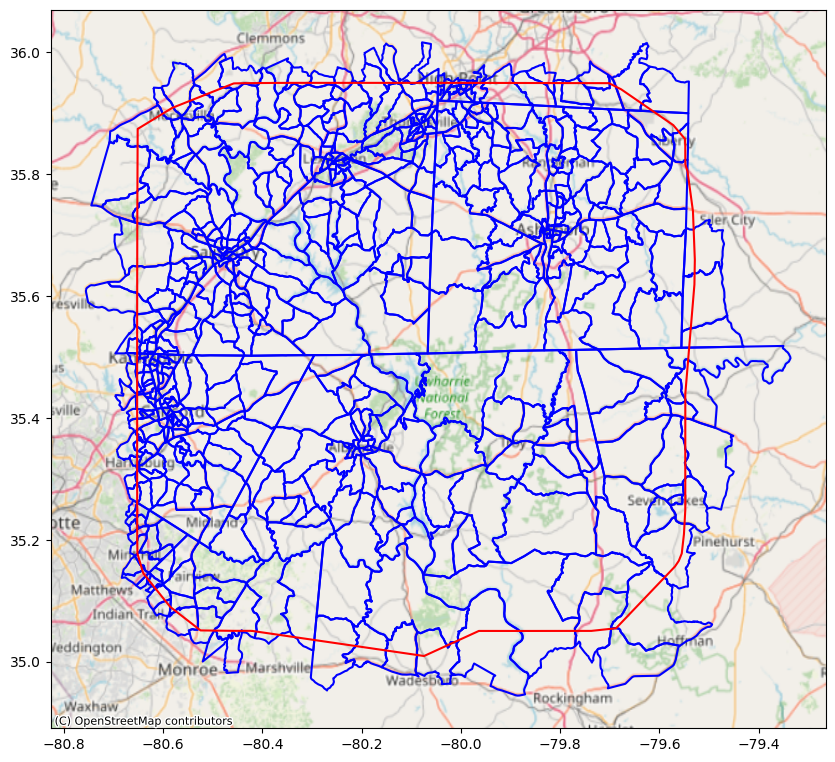

In [28]:
# load census block group boundaries
file_path = '/Users/mihiarc/Work/data/'
block_groups = gpd.read_file(file_path + 'spatial-boundaries/cb_2023_us_bg_500k/cb_2023_us_bg_500k.shp')

# Filter block groups to only include those within the isochrone polygon
block_groups_isochrone = block_groups[block_groups.intersects(isochrone_polygon)]

# Plot the block groups and isochrone
fig, ax = plt.subplots(figsize=(10, 10))
block_groups_isochrone.boundary.plot(ax=ax, color='blue')
isochrone_gdf.boundary.plot(ax=ax, color='red')
ctx.add_basemap(ax, crs = block_groups_isochrone.crs, source = ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [29]:
# recreate the previous map using folium for an interactive map
import folium
from folium.plugins import MarkerCluster

# Create a folium map
m = folium.Map(location=[35.454, -80.079], zoom_start=10)

# Add the isochrone polygon to the map with 0.05 opacity and green fill color and red boundary
folium.GeoJson(
    isochrone_gdf,
    style_function=lambda x: {'fillColor': 'purple', 'color': 'red', 'fillOpacity': 0.4}
).add_to(m)

# Add the block groups to the map
folium.GeoJson(block_groups_isochrone).add_to(m)

# Add a marker for the trail head
folium.Marker([35.454, -80.079], popup='Trail Head').add_to(m)

# Display the map
m

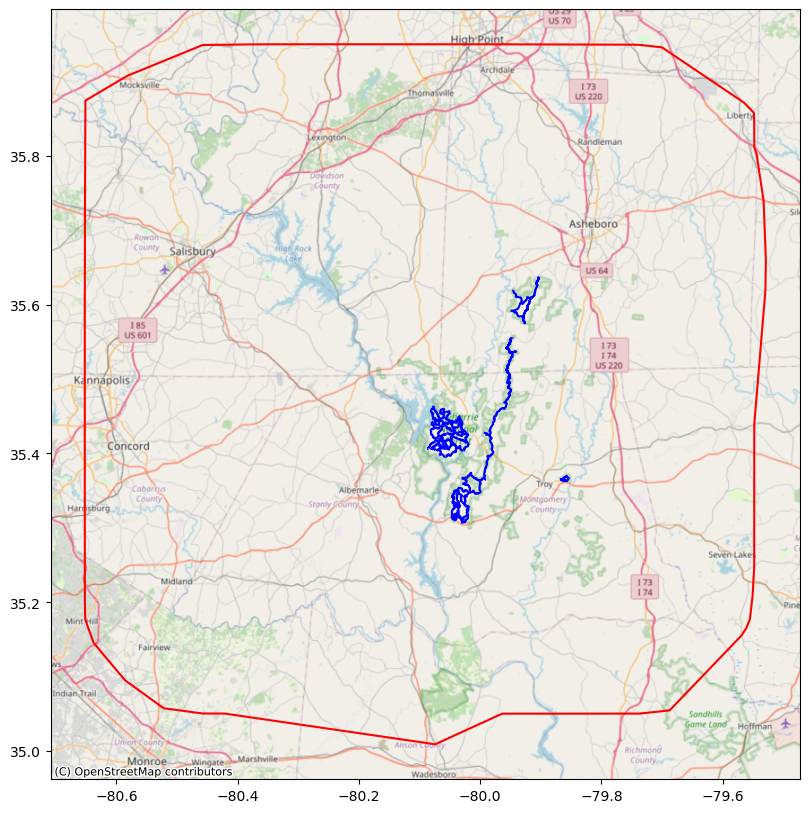

In [14]:
import contextily
import matplotlib.pyplot as plt
# clip the trails to the isochrone polygon
nfs_trails_isochrone = gpd.clip(nfs_trails, isochrone_polygon)

# Plot the trails and isochrone
fig, ax = plt.subplots(figsize=(10, 10))
nfs_trails_isochrone.plot(ax=ax, color='blue')
isochrone_gdf.boundary.plot(ax=ax, color='red')
ctx.add_basemap(ax, crs = nfs_trails_isochrone.crs, source = ctx.providers.OpenStreetMap.Mapnik)
plt.show()

4. Intersect Catchment Areas with Population Data

* Overlay the service area polygons (for both public transport and private autos) onto the urban population data.

* For each urban area (e.g., census block or neighborhood), identify which areas fall within the catchment of the forest for each travel mode.

* For each mode of travel, calculate the total population within the defined service area of the forest. This gives you the catchment population for each forest based on the mode of travel.

5. Compare Catchment Areas for Different Modes of Travel

* For each forest, compare the population that can access the forest via public transport versus private autos. 

* Map the catchment areas and highlight areas where access is more limited by one mode of travel compared to the other.

* Use heatmaps or color-coded maps to show catchment areas for both travel modes. For instance, areas where both public transport and private auto access are high could be shown in one color, while areas accessible only by private auto (or public transport) could be shown in a different color.

* Consider using a difference map to show areas where private autos have better access than public transport (or vice versa).

6. Quantify Accessibility Metrics

- Population Coverage: Calculate the total population served by each mode of travel within

- Access Equity: Calculate the percentage of the population that only has access via public transport, only via private auto, or both.
    
- Forest Catchment Index: Create an index that combines accessibility by both modes of transport. For example:

Accessibility Index=  (〖Catchment〗_public+〖Catchment〗_auto)/(Total Population in Urban Area)

This index would indicate how accessible the forest is overall from a given urban area.


7. Mapping the Results

* Catchment Area Maps: Create maps that clearly display the service areas for public transport and private auto access. These maps should:

    * Differentiate between travel modes (e.g., shading for public transport and different shading for private auto).

    * Show the overlap of these catchment areas, revealing areas where both modes provide access.

* Equity Analysis Maps: Create additional maps showing areas where public transport access is lacking, and only private auto access exists. This helps identify gaps in transportation infrastructure for equitable access to forest recreation.

* Travel Time Comparison: Use contour maps or gradients to display the travel time differences between the two modes of transport to each forest.


8. Refining and Presenting Results

* Scenario Testing: Run the analysis under different scenarios, such as:
    - Varying public transport schedules (e.g., peak vs. off-peak).
    - Different travel time thresholds.
* Reporting: Summarize the results with visuals, tables, and key statistics, such as:
    - The proportion of the urban population that can access the forest within 30 minutes by public transport vs. private auto.
    - Identification of underserved areas that lack sufficient access to forest recreation by any travel mode
